### Load swaption vol surface data

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import QuantLib as ql
from pysabr import Hagan2002LognormalSABR
from pysabr import Hagan2002NormalSABR
from pysabr.helpers import year_frac_from_maturity_label

### Example 1: Lognormal SABR vs Normal SABR

In [65]:

# vols_csv = './data/vols.csv'
vols_csv = os.path.join('.', 'data', 'vols.csv')
df = pd.read_csv(vols_csv)
df.set_index(['Type', 'Option_expiry'], inplace=True)
df.sort_index(inplace=True)
idx = pd.IndexSlice
# df.head()

In [66]:
option_expiries = ['1M', '1Y', '10Y']
swap_tenors = ['2Y', '10Y', '30Y']
m = len(option_expiries); n = len(swap_tenors)
swaption_grid = list(itertools.product(*[option_expiries, swap_tenors]))
n_strikes = 100
strikes = np.linspace(-1.00, 6.00, n_strikes)

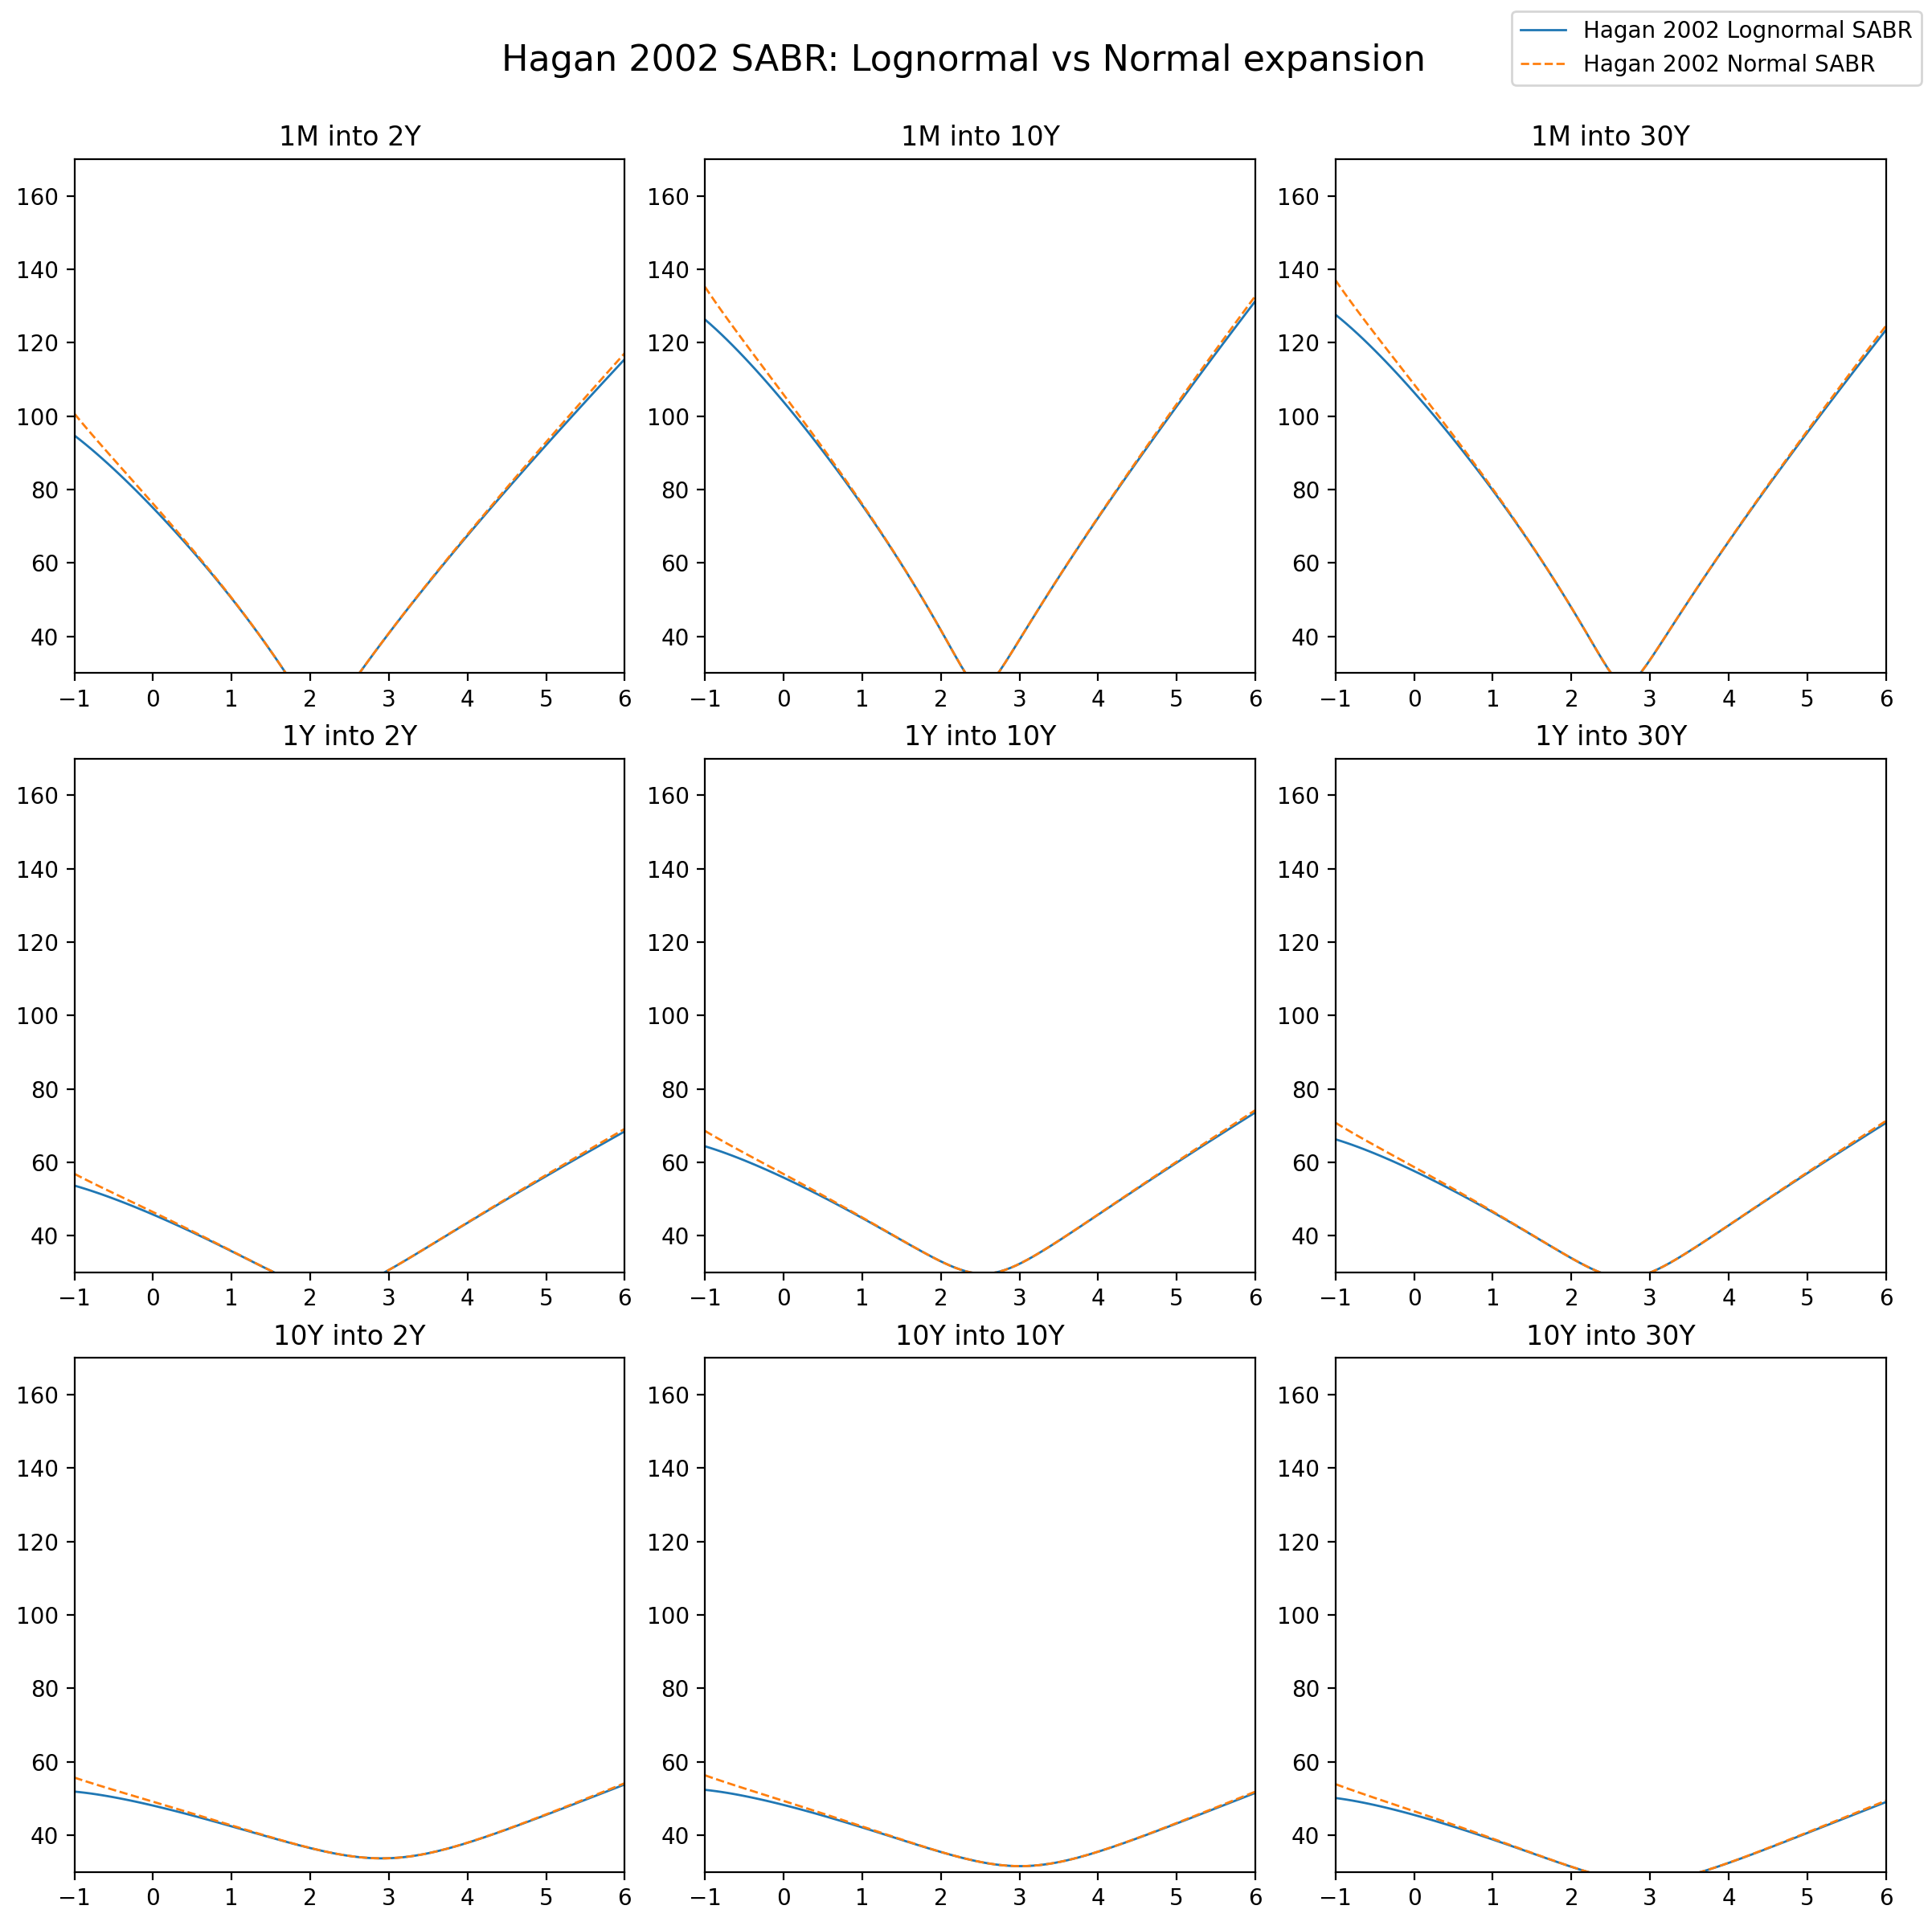

In [67]:
fig, axes = plt.subplots(m, n)
fig.set_dpi(200)
fig.set_size_inches((12, 12))
fig.tight_layout(w_pad=0.5, h_pad=2.0)

for ((option_expiry, swap_tenor), ax) in zip(swaption_grid, fig.get_axes()):
    beta, f, v_atm_n, rho, shift, volvol = list(df.loc[idx[:, option_expiry], swap_tenor].reset_index(level=1, drop=True))
    t = year_frac_from_maturity_label(option_expiry)
    sabr_ln = Hagan2002LognormalSABR(f/100, shift/100, t, v_atm_n/1e4, beta, rho, volvol)
    sabr_n = Hagan2002NormalSABR(f/100, shift/100, t, v_atm_n/1e4, beta, rho, volvol)
    sabr_ln_vols = [sabr_ln.normal_vol(k/100) * 1e4 for k in strikes]
    sabr_n_vols = [sabr_n.normal_vol(k/100) * 1e4 for k in strikes]
    ax.plot(strikes, sabr_ln_vols, linewidth=1.0, linestyle='-')
    ax.plot(strikes, sabr_n_vols, linewidth=1.0, linestyle='--')
    ax.set_xlim((-1.0, 6.0))
    ax.set_ylim((30., 170.))
    ax.set_title("{} into {}".format(option_expiry, swap_tenor))

line_sabr_ln = axes[0][0].get_lines()[0]
line_sabr_n = axes[0][0].get_lines()[1]
fig.legend(handles=(line_sabr_ln, line_sabr_n), labels=('Hagan 2002 Lognormal SABR', 'Hagan 2002 Normal SABR'), loc='upper right')
fig.suptitle("Hagan 2002 SABR: Lognormal vs Normal expansion", fontsize=16)
fig.subplots_adjust(top=0.92)
# fig.savefig("./output/Lognormal SABR vs Normal SABR.pdf", format='pdf')

In [46]:
fig.savefig("./output/Lognormal SABR vs Normal SABR,beta0.4.pdf", format='pdf')

### Example 2: SABR calibration (Manually vs pysabr)

0.04852594036052043
vols manually [0.40321511 0.39723399 0.3915307  0.38608861 0.38089281 0.37592985
 0.37118755 0.36665488 0.36232175 0.35817896 0.35421802 0.35043113
 0.34681106 0.34335109 0.34004496 0.33688679 0.33387107 0.33099257
 0.32824636 0.32562774 0.32313222 0.3207555  0.31849344 0.31634205
 0.31429748 0.31235599 0.31051397 0.30876788 0.30711428 0.30554982
 0.30407124 0.30267535 0.30135902 0.30011921 0.29895296 0.29785735
 0.29682956 0.29586683 0.29496648 0.29412589 0.29334252 0.2926139
 0.29193764 0.29131142 0.290733   0.29020019 0.28971091 0.28926313
 0.2888549  0.28848434 0.28814964 0.28784908 0.28758097 0.28734373
 0.28713582 0.28695577 0.28680218 0.2866737  0.28656905 0.286487  ]
vols_sabr_n from pysabar [0.42859728 0.42169184 0.41512277 0.40886176 0.40288377 0.39716655
 0.39169026 0.38643711 0.38139114 0.37653794 0.37186451 0.36735904
 0.3630108  0.35881001 0.35474772 0.35081574 0.34700657 0.34331329
 0.33972951 0.33624937 0.33286741 0.32957859 0.32637821 0.32326194
 0.

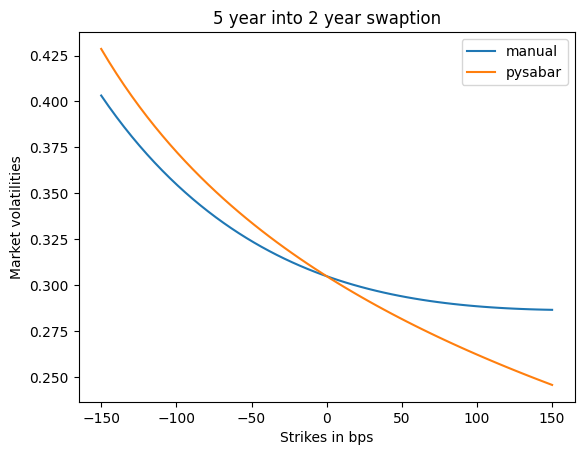

In [15]:
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def main(): 
    #A good fit can be obtained for any 0<=beta<=1. Often beta=0,1/2 or beta=1
    #is choosen, depending on the market.
    beta = 0.5
    #The current forward price
    f =  0.028436364   
    #The time to the expiry of the option
    t_exp = 5
    #The tenor of the option
    tenor = 2
    #A list of market volatilities at strikes corropsponding to strikes_in_bps below. 
    sigmas = np.array([0.4040, 0.3541, 0.3218, 0.3107, 0.3048, 0.2975, 0.2923, 0.2873, 0.2870])
    #The 'At the money volatility', corrosponding to a strike equal to the current forward price.
    atm_sigma = 0.3048
    #A list of strikes in bps (=0.0001) corrosponding to volatilites in sigmas
    strikes_in_bps = np.array([-150,-100,-50,-25,0,25,50,100,150])
    #An inital guess of the parameters alpha, nu and rho.
    guess = [0.01, 10,-0.5]
    
    #calculating the actual strikes from f and strikes_in_bps
    strikes = f + strikes_in_bps*0.0001
    #Calling the SABR_calibration function defined below to return the parameters.
    alpha, nu, rho = SABR_calibration(f, t_exp, atm_sigma, beta, strikes, sigmas, guess)
    print(alpha)
    
    #This nextsection of code simply draws a plot.
    Ks_in_bps = np.linspace(-150,150,60)
    Ks = f + Ks_in_bps*0.0001
    vols_from_Ks = SABR_market_vol(Ks,f,t_exp,alpha,beta,nu,rho)
    print('vols manually',vols_from_Ks)
    shift = 0
    # sabr_ln = Hagan2002LognormalSABR(f, shift/100, t_exp, atm_sigma, beta, rho, nu)
    sabr_n = Hagan2002NormalSABR(f, shift/100, t_exp, atm_sigma, beta, rho, nu)
    # sabr_ln_vols = np.array([sabr_ln.normal_vol(k) for k in Ks])
    sabr_n_vols = np.array([sabr_n.normal_vol(k) for k in Ks])
    # print('vols_sabr_ln from pysabar',sabr_ln_vols)
    # sabr_n_vols_ql = np.array([ql.sabrVolatility(k, f, t_exp, atm_sigma, beta, nu, rho) for k in Ks])
    # sabrVolatility
    # shiftedSabrVolatility
    print('vols_sabr_n from pysabar',sabr_n_vols)
    # print('vols_sabr_n from quantlib',sabr_n_vols_ql)
    # textbox = "\n".join((r"$\alpha=$"+f"{round(alpha,6)}",r"$\beta=$"+f"{beta}",
    #                     r"$\rho=$"+f"{round(rho,6)}", r"$\nu=$"+f"{round(nu,6)}"))
    fig, ax = plt.subplots()
    # plt.plot(strikes_in_bps, sigmas, 'x')
    plt.plot(Ks_in_bps,vols_from_Ks)
    plt.plot(Ks_in_bps,sabr_n_vols)
    plt.legend(['manual','pysabar'])
    plt.xlabel("Strikes in bps")
    plt.ylabel("Market volatilities")
    plt.title(f"{t_exp} year into {tenor} year swaption")
    # plt.text(0.6, 0.9, textbox, transform=ax.transAxes, fontsize=10,
    #     verticalalignment='top',bbox=dict(facecolor='white', alpha=0.7))
    
    #Saving the plot if desired.
    #plt.savefig(f"{t_exp} year into {tenor} year swaption"+".png")        

def SABR_market_vol(K,f,t_exp,alpha,beta,nu,rho):
    '''Given a list of strike prices and SABR parameters, returns what the SABR
    model predicts the market volatility to be. Calculated from equations (2.17) 
    and (2.18) in Hagan, Patrick S., Deep Kumar, Andrew S. Lesniewski, and 
    Diana E. Woodward "Managing smile risk." The Best of Wilmott 1 (2002): 249-296.
    '''
    output = np.zeros(len(K))
    
    for i in range(0,len(K)):
        if K[i] == f: #ATM equation in Managing smile risk
            part_1 = (1.0 - beta)**2.0*alpha**2.0/(24.0*f**(2.0 - 2.0*beta))
            part_2 = rho*beta*alpha*nu/(4.0*f**(1.0 - beta))
            part_3 = (2.0 - 3.0*rho**2)*nu**2.0/24.0
            
            output[i] = (alpha/f**(1 - beta))*(1 + (part_1 + part_2 + part_3)*t_exp )
        
        else:
            logfK = np.log(f/K[i])
            fkbpow = (f*K[i])**((1.0 - beta)/2.0)
            z = nu*fkbpow*logfK/alpha
            xz = np.log((np.sqrt(1.0 - 2.0*rho*z + z**2.0 ) + z - rho)/(1.0-rho))
            
            part_1 = ((1.0-beta)**2.0)*(alpha**2.0)/(24.0*fkbpow**2.0)
            part_2 = (rho*beta*nu*alpha)/(4.0*fkbpow)
            part_3 = (2.0-3.0*rho**2)*nu**2.0/24.0
            part_4 = ((1.0-beta)**2)*(logfK**2)/24.0
            part_5 = ((1.0-beta)**4)*(logfK**4)/1920.0
            
            output[i] = (alpha*z*(1 + (part_1 + part_2 + part_3)*t_exp ))/(fkbpow*xz*(1 + part_4 + part_5 ))
            
    return output

def atm_sigma_to_alpha(f,t_exp,sigma_atm,beta,nu,rho):
    '''Returns alpha given the forward price, the at-the-money volatility, the 
    time to exirpy (t_exp) and the other parameters in the SABR model by 
    solving a cubic equation for alpha, equation (2.18) in Hagan, Patrick S., 
    Deep Kumar, Andrew S. Lesniewski, and Diana E. Woodward. 
    "Managing smile risk." The Best of Wilmott 1 (2002): 249-296. 
    '''
    #The coeffceints of the polynomial we find the roots of
    p_3 = -sigma_atm
    p_2 =  (1 + (2-3*rho**2)*nu**2*t_exp/24)/f**(1.-beta)
    p_1 = rho*beta*nu*t_exp/(4*f**(2-2*beta))
    p_0 = (1-beta)**2*t_exp/(24*f**(3-3*beta))
    coeffs = [p_0,p_1,p_2,p_3]
    
    r = np.roots(coeffs)    #find the roots of the cubic equation
    
    return r[(r.imag==0) & (r.real>=0)].real.min() 

def SABR_calibration(f, t_exp, sigma_atm, beta, strikes, vols,guess):
    ''' Returns the parameters alpha, nu and rho given a parameter beta, 
    forward price, a list of market volatilities and corrsponding strike 
    spread. Instead of doing a regression in all three parameters, this method 
    calculates alpha when needed from nu and rho. Hence a regression is done 
    in only two variables.
    '''
    def func_to_optimize(K,nu,rho):
        alpha = atm_sigma_to_alpha(f,t_exp,sigma_atm,beta,nu,rho)
        return  SABR_market_vol(K,f,t_exp,alpha,beta,nu,rho)
     
    popt, pcov = curve_fit(func_to_optimize, strikes, vols, p0 = (guess[1],guess[2]), maxfev=10000)
      
    nu = popt[0]
    rho = popt[1]
    alpha = atm_sigma_to_alpha(f,t_exp,sigma_atm,beta,nu,rho)
    
    return [alpha, nu, rho]
        
if __name__ == "__main__": main()

    
    
    
    

### Pysabr

In [15]:
# Forward = 2.5%, Shift = 3%, ATM Normal Vol = 40bps
# Beta = 0.5, Rho = -20%, Volvol = 0.30
f = 0.025
shift = 0.03
t=1.
vol=0.004
beta=0.5
rho=-0.2
volvol=0.3
k = 0.025

In [19]:
sabr = Hagan2002LognormalSABR(f=f, 
                              shift=shift, 
                              t=t, 
                              v_atm_n=vol,
                              beta=beta, 
                              rho=rho, 
                              volvol=volvol)

print(sabr.lognormal_vol(k) * 100)
# returns 7.27
print(sabr.normal_vol(k) *1e4)
# returns 40

7.274330790834249
39.99999984043036


In [20]:
sabr = Hagan2002NormalSABR(f=f, 
                           shift=shift,
                           t=t,
                           v_atm_n=vol,
                           beta=beta,
                           rho=rho,
                           volvol=volvol)

print(sabr.lognormal_vol(k) * 100)
# returns 7.27
print(sabr.normal_vol(k) *1e4)
# returns 40

7.274330791218005
40.00000000000001


### QuantLib

In [ ]:
# Forward = 2.5%, Shift = 3%, ATM Normal Vol = 40bps
# Beta = 0.5, Rho = -20%, Volvol = 0.30
f = 0.025
shift = 0.03
t=1.
vol=0.004
beta=0.5
rho=-0.2
volvol=0.3
k = 0.025

In [36]:
print(ql.sabrVolatility(k, f, t/365, vol*10000, beta, volvol, rho/100)/100)

7.137399992981659


In [38]:
print(ql.shiftedSabrVolatility(k, f, t/365, vol*10000, beta, volvol, rho/100, shift*10000))

2.3097026761925674


In [24]:
print(ql.sabrFlochKennedyVolatility(strike=k,
                                    forward=f,
                                    expiryTime=t,
                                    alpha=vol,
                                    beta=beta,
                                    nu=volvol,
                                    rho=rho))

0.025471942396189075
